# This is the implementation of non-machine learning based image fusion using guided filtering model 
http://www.exppad.com/gff/notebook.html  
http://www.exppad.com/gff/

In [1]:
#Import packages
import time
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.vgg import vgg19
import torch.nn as nn
import torch.nn.functional as F
import torch
from skimage import img_as_ubyte
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # dataset
import matplotlib.pyplot as plt
import scipy
import numpy as np
import argparse
import glob
import imageio
from skimage import color
import numpy
import natsort
import scipy
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import pprint
from scipy.ndimage import correlate
from scipy.ndimage.filters import gaussian_gradient_magnitude
from scipy.misc import toimage, imsave
from scipy.ndimage.filters import laplace
from scipy.ndimage import uniform_filter, gaussian_filter
import torchvision.datasets as dset
import torch.utils.data as data
import os
import os.path
from tkinter import *
import tkinter as tk
import tkinter.font as tkFont
from PIL import ImageTk, Image
import pylab
import cv2
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_properties(0).total_memory)

11811160064


In [3]:
import multiprocessing

multiprocessing.cpu_count()

12

In [4]:
#define the hyperparameters
image_length = 256
image_width  = 256
mr_channels  = 1
gray_channels = 1
pet_channels = 4    
rgb_channels = 3     
batch_size   = 2
EPOCH = 50
learning_rate = 0.002 

In [52]:
#load the test input MRI dataset
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis/MRI/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis/MRI/')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
test_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_mri[i,:,:] =(imageio.imread(data[i]))
    test_mri[i,:,:] =(test_mri[i,:,:] - np.min(test_mri[i,:,:])) / (np.max(test_mri[i,:,:]) - np.min(test_mri[i,:,:]))
    test_mri[i,:,:] = np.float32(test_mri[i,:,:])

In [53]:
#expand dimension to add the channel
test_mri = np.expand_dims(test_mri,axis=1)
#verify the shape matches the pytorch standard
test_mri.shape

(1, 1, 256, 256)

In [54]:
#convert the MRI Testing data to pytorch tensor
test_mri_tensor = torch.from_numpy(test_mri).float()
test_mri_tensor = test_mri_tensor.to(device)
print(test_mri_tensor.shape)
test_mri_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


In [55]:
#load the test input PET dataset
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis/PET/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis/PET/')
data = glob.glob(os.path.join(dataset, "*.png"))
data = natsort.natsorted(data,reverse=False)
test_pet = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_pet[i,:,:] =(imageio.imread(data[i]))
    test_pet[i,:,:] =(test_pet[i,:,:] - np.min(test_pet[i,:,:])) / (np.max(test_pet[i,:,:]) - np.min(test_pet[i,:,:]))
    test_pet[i,:,:] = np.float32(test_pet[i,:,:])

In [56]:
#expand dimension to add the channel
test_pet = np.expand_dims(test_pet,axis=1)
#verify the shape matches the pytorch standard
test_pet.shape

(1, 1, 256, 256)

In [57]:
#convert the MRI Testing data to pytorch tensor
test_pet_tensor = torch.from_numpy(test_pet).float()
test_pet_tensor = test_pet_tensor.to(device)
print(test_pet_tensor.shape)
test_pet_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


In [125]:
#define the network
class Gaussian_Filtering(nn.Module):
    def  __init__(self):
        super(Gaussian_Filtering, self).__init__()
        #####mri lf layer #####
        self.mri_lf =  nn.Conv2d(in_channels=1, out_channels=1, kernel_size=9, stride=1, padding=4)
        torch.nn.init.normal_(self.mri_lf.weight, mean=0.0, std=1.0)   
        #####mri hf layer #####
        self.mri_hf = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size  = 3, stride= 1, padding = 1)
        torch.nn.init.normal_(self.mri_hf.weight, mean=0.0, std=1.0)
        #####pet lf layer #####
        self.pet_lf = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=7, stride=1, padding=3)
        torch.nn.init.normal_(self.pet_lf.weight, mean=0.0, std=1.0)
        #####pet hf layer #####
        self.pet_hf = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size  = 5, stride= 1, padding = 2)
        torch.nn.init.normal_(self.pet_hf.weight, mean=0.0, std=1.0)

    def forward(self, x, y):
        #mri lf layer 1
        x1 = self.mri_lf(x)
        x1 = nn.ReLU(x1)
        #mri hf layers
        x2 = self.mri_hf(x)
        x2 = nn.ReLU(x2)
        #pet lf layer 1
        y1 = self.pet_lf(y)
        y1 = nn.ReLU(y1)
        #pet hf layers
        y2 = self.pet_hf(y)
        y2 = nn.ReLU(y2)
        #high frequency fusion layer
        fuse_hf = (x2 + y2)/2
        #low frequency fusion layer
        fuse_lf = (x1 + y1)/2
        #final fusion layer
        fused = fuse_hf + fuse_lf
        #tanh layer
        fused = torch.tanh(fused)      
        return fused
        #execute the network

model0 = Gaussian_Filtering().to(device)
model0 = model0.float()
print(model0)

Gaussian_Filtering(
  (mri_lf): Conv2d(1, 1, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (mri_hf): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pet_lf): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pet_hf): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [126]:
model0.eval()

Gaussian_Filtering(
  (mri_lf): Conv2d(1, 1, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (mri_hf): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pet_lf): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pet_hf): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [127]:
#predicted the fused image
fused = model0(test_mri_tensor.to(device), test_pet_tensor.to(device))
fused_numpy = fused.data.cpu().numpy()
fused_numpy = fused_numpy

TypeError: unsupported operand type(s) for +: 'ReLU' and 'ReLU'

In [118]:
fused.shape

torch.Size([1, 1, 256, 256])

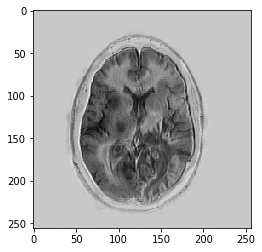

In [119]:
#verify the output image
plt.imshow(fused_numpy[0,0,:,:],'gray')
#plt.savefig('Fused.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [120]:
np.min(fused_numpy)

-0.8036332

In [65]:
imageio.imwrite('C:/Users/horan/Desktop/FuseVis/Fused/Gaussian Filtering/Fused.png',np.uint8(cv2.normalize(fused_numpy[0,0,:,:], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)))

In [66]:
#calculate the guidance image for MRI and PET wrt to the fused image
time1 = time.time()
count = 0 
guide_fuse_mri = np.zeros((256,256),dtype=float)
guide_fuse_pet = np.zeros((256,256),dtype=float)
for y_coord in range(0,256):
    for x_coord in range(0,256):
        jacob_fuse_mri = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_mri_tensor, retain_graph=True, create_graph=True)[0]
        jacob_numpy_mri = np.squeeze(jacob_fuse_mri.data.cpu().numpy())  
        guide_fuse_mri[y_coord,x_coord] = jacob_numpy_mri[y_coord,x_coord]
        jacob_fuse_pet = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_pet_tensor, retain_graph=True, create_graph=True)[0]
        jacob_numpy_pet = np.squeeze(jacob_fuse_pet.data.cpu().numpy())  
        guide_fuse_pet[y_coord,x_coord] = jacob_numpy_pet[y_coord,x_coord]
        count += 1
        if count % 10000 == 0:
            print('Count is %d' %count)
time2 = time.time()
print('Time taken to compute is %d seconds' %(time2-time1))

Count is 10000
Count is 20000
Count is 30000
Count is 40000
Count is 50000
Count is 60000
Time taken to compute is 193 seconds


In [ ]:
#hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/H5 Files/Jacobian_MRI.h5', 'r')
#guide_fuse_mri =  np.array(hf.get('MRI_dataset'))
#hf.close()

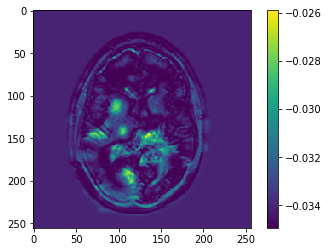

In [67]:
plt.imshow(guide_fuse_mri,cmap='viridis')
plt.colorbar()
#plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Guide_Fused_MRI_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/H5 Files/Jacobian_PET.h5', 'r')
#guide_fuse_pet =  np.array(hf.get('PET_dataset'))
#hf.close()

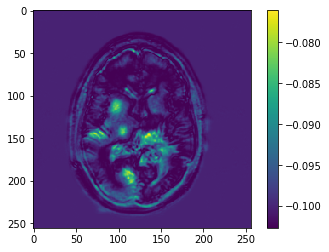

In [70]:
plt.imshow(guide_fuse_pet,cmap='viridis')
plt.colorbar()
#plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Guide_Fused_PET_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [71]:
#define overlay images
fused_RGB = np.zeros((256,256,3),dtype=float)
mri_RGB   = np.zeros((256,256,3),dtype=float)
pet_RGB   = np.zeros((256,256,3),dtype=float)

In [72]:
fused_RGB[:,:,0]  = guide_fuse_mri 
fused_RGB[:,:,1]  = guide_fuse_pet 
fused_RGB[:,:,2]  = fused_numpy[0,0,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


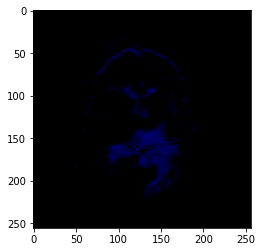

In [73]:
plt.imshow(fused_RGB)
#plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Fused_RGB_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#h5f = h5py.File('C:/Users/horan/Desktop/FuseVis/Jacobian_MRI.h5', 'w')
#h5f.create_dataset('MRI_dataset', data=guide_fuse_mri)
#h5f.close()

In [ ]:
#h5f = h5py.File('C:/Users/horan/Desktop/FuseVis/Jacobian_PET.h5', 'w')
#h5f.create_dataset('PET_dataset', data=guide_fuse_pet)
#h5f.close()

In [ ]:
#hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/H5 Files/Jacobian_MRI.h5', 'r')
#guide_fuse_mri =  np.array(hf.get('MRI_dataset'))
#hf.close()

In [ ]:
#hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/H5 Files/Jacobian_PET.h5', 'r')
#guide_fuse_pet =  np.array(hf.get('PET_dataset'))
#hf.close()

In [ ]:
#define the window
root = Tk()  
root.title('Visualisation of fusion networks')
root.configure(background='white')


#Label the images
#fontStyle = tkFont.Font(family="Lucida Grande", size=15)
#w1 = tk.Label(root, bg='white', font=fontStyle, text="Fused Image")
#w1.grid(row=0, column=1)
#w1.pack()

#define the frame
canvasframe = Frame(root)  # define Input and output frame
buttonframe = Frame(root)  # define button frame
canvasframe.pack()  # pack the Input and Output frame
buttonframe.pack()  # pack the button frame


#define the canvas
canvas = Canvas(canvasframe, width=1800, height=920, bg = 'white')
canvas.grid(row=0, column=0)

#Insert fused image to the canvas
img_fused = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/Fused/FunFuseAn/Fused.png") # load the image
canvas.create_image(0, 0, image=img_fused, anchor=NW)

#Insert MRI image to the canvas
img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/MRI/MRI.gif") # load the image
canvas.create_image(600, 0, image=img_mri, anchor=NW)

#Insert PET image to the canvas
img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/PET/3.png") # load the image
canvas.create_image(1200, 0, image=img_pet, anchor=NW)

def start_mouseover():  # function called when user clicks the button 
    # link the function to the left-mouse-click event
    canvas.bind("<B1-Motion>", Coordinates)

def Coordinates(event): # function called when left-mouse-button is clicked with a mouseover
    x_coord = event.x  # save x and y coordinates selected by the user   
    y_coord = event.y
    print('mouse position is at' + '(' + str(y_coord) + ',' + str(x_coord) + ')', end='\r')
    #display the output MRI Jacobian image
    #img_MR_out = ImageTk.PhotoImage(file ='C:/Users/cgvadmin/Desktop/FuseVis/Fused_MRI/im_' + str(y_coord) + '_' + str(x_coord) + '.png') # load the image
    jacobian_fuse_mri = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_mri_tensor, retain_graph=True, create_graph=True)[0]
    jacobian_fuse_pet = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_pet_tensor, retain_graph=True, create_graph=True)[0]
    
    jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
    jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
    
    x_mri = np.asarray(np.where(np.any(jacob_val_mri, axis = 0)))
    y_mri = np.asarray(np.where(np.any(jacob_val_mri, axis = 1)))
    minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
    zoom_im_mri = jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri] 
    
    x_pet = np.asarray(np.where(np.any(jacob_val_pet, axis = 0)))
    y_pet = np.asarray(np.where(np.any(jacob_val_pet, axis = 1)))
    minx_pet, maxx_pet, miny_pet, maxy_pet = np.min(x_pet), np.max(x_pet), np.min(y_pet), np.max(y_pet)  #return min and max coordinates
    zoom_im_pet = jacob_val_pet[miny_pet:maxy_pet,minx_pet:maxx_pet] 
    
    plt.imshow(fused_numpy[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom Fused')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Zoom_Fused.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out11 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Zoom_Fused.png')
    canvas.create_image(300,5,image=im_out11,anchor=NW)
    canvas.image11 = im_out11
    plt.tight_layout()
    
    plt.imshow(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom MRI')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Zoom_MRI.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out12 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Zoom_MRI.png')
    canvas.create_image(900,5,image=im_out12,anchor=NW)
    canvas.image12 = im_out12
    plt.tight_layout()
    
    plt.imshow(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom PET')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Zoom_PET.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out13 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Zoom_PET.png')
    canvas.create_image(1500,5,image=im_out13,anchor=NW)
    canvas.image13 = im_out13
    plt.tight_layout()
    
    plt.imshow(jacob_val_mri,cmap='viridis', aspect ='equal')
    plt.title('Jacobian (Fused wrt MRI)')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Jacob_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out1 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Jacob_Fused_MRI.png')
    canvas.create_image(40,320,image=im_out1,anchor=NW)
    canvas.image1 = im_out1
    #plt.tight_layout()
    
    #f.add_subplot(1,5,2)
    plt.imshow(zoom_im_mri,cmap='viridis',aspect ='equal')
    plt.title('Zoom Jacobian (Fused wrt MRI)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Zoom_Jacob_MRI.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out2 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Zoom_Jacob_MRI.png')
    canvas.create_image(380,320,image=im_out2,anchor=NW)
    canvas.image2 = im_out2
    
    #f.add_subplot(1,5,3)
    plt.xlim(0,0.7)
    plt.ylim(0,0.7)
    plt.plot(jacob_val_mri[y_coord,x_coord],jacob_val_pet[y_coord,x_coord],'-ro')
    plt.xlabel('MRI pixel score (Fused wrt MRI)')
    plt.ylabel('PET pixel score (Fused wrt PET)')
    plt.title('Mouse position at: (' + str(y_coord) + ',' + str(x_coord) + ')')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Pixel_intensities.png', bbox_inches = 'tight',pad_inches = 0.1)
    plt.close()
    im_out3 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Pixel_intensities.png')
    canvas.create_image(750,320,image=im_out3,anchor=NW)
    canvas.image3 = im_out3
    
    #f.add_subplot(1,5,4)
    plt.imshow(jacob_val_pet,cmap='viridis',aspect ='equal')
    plt.title('Jacobian (Fused wrt PET)')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Jacob_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out4 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Jacob_Fused_PET.png')
    canvas.create_image(1110,320,image=im_out4,anchor=NW)
    canvas.image4 = im_out4
    #plt.tight_layout()
    
    #f.add_subplot(1,5,5)
    plt.imshow(zoom_im_pet,cmap='viridis',aspect ='equal')
    plt.title('Zoomed Jacobian (Fused wrt PET)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Zoom_Jacob_PET.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Zoom_Jacob_PET.png')
    canvas.create_image(1450,320,image=im_out5,anchor=NW)
    canvas.image5 = im_out5

    plt.imshow(guide_fuse_mri,cmap='viridis')
    plt.title('Guidance (Fused wrt MRI)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out6 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Guide_Fused_MRI.png')
    canvas.create_image(100,650,image=im_out6,anchor=NW)
    canvas.image6 = im_out6
    
    plt.imshow(fused_RGB)
    plt.title('R=I1 G=I2 B=Fused')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out8 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Fused_RGB.png')
    canvas.create_image(420,650,image=im_out8,anchor=NW)
    canvas.image8 = im_out8
    
    plt.imshow(mri_RGB)
    plt.title('R=I1 G=I2 B=MRI')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/MRI_RGB.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out9 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/MRI_RGB.png')
    canvas.create_image(740,650,image=im_out9,anchor=NW)
    canvas.image9 = im_out9
    
    plt.imshow(pet_RGB)
    plt.title('R=I1 G=I2 B=PET')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/PET_RGB.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out10 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/PET_RGB.png')
    canvas.create_image(1100,650,image=im_out10,anchor=NW)
    canvas.image10 = im_out10
    
    plt.imshow(guide_fuse_pet,cmap='viridis')
    plt.title('Guidance (Fused wrt PET)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out7 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Guide_Fused_PET.png')
    canvas.create_image(1400,650,image=im_out7,anchor=NW)
    canvas.image7 = im_out7
    
    radius = 5
    i = canvas.create_oval(x_coord-radius, y_coord-radius, x_coord+radius, y_coord+radius, fill = 'red')
    canvas.after(20,canvas.delete,i)

# insert button to the middleframe and link it to "Start Mouseover"
button_start_mouseover = Button(buttonframe, text="Start Mouseover",command=start_mouseover)
button_start_mouseover.grid(row=1, column=0, pady=0)


root.mainloop()  #keep the GUI open